In [20]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from collections import OrderedDict
from textwrap import wrap

In [21]:
df = pd.read_json('./Data/db_export.csv', encoding='ISO-8859-1')
df.info()
df.head()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 21 columns):
1_1                      58 non-null int64
1_2                      58 non-null int64
1_3                      58 non-null int64
1_4                      58 non-null int64
1_5                      58 non-null int64
1_6                      58 non-null object
2_1                      58 non-null object
2_2                      58 non-null int64
2_3                      58 non-null int64
2_4                      58 non-null int64
3_1                      58 non-null int64
3_2                      58 non-null int64
3_3                      58 non-null int64
3_4                      58 non-null int64
3_5                      58 non-null int64
3_6                      58 non-null int64
3_7                      58 non-null int64
computerButtonClicked    58 non-null int64
email                    58 non-null object
themeChosen              58 non-null int64
timeToComplete           58 non-nu

,1_1,1_2,1_3,1_4,1_5,1_6,2_1,2_2,2_3,2_4,...,3_2,3_3,3_4,3_5,3_6,3_7,computerButtonClicked,email,themeChosen,timeToComplete
0,2,1,1,2,2,"[1, 2, 4, 5]","[1, 7]",1,2,2,...,4,3,4,3,2,1,0,tlkramer@smu.edu,3,51.131
1,1,1,1,1,1,"[1, 3, 4, 5, 6]",[5],2,2,2,...,4,3,4,3,2,1,0,dcsanchez@smu.edu,1,317.141
2,2,1,1,2,2,"[1, 2, 4, 5]",[5],1,2,2,...,3,2,3,2,3,1,0,ccjohnson@smu.edu,1,179.159
3,1,1,1,2,3,"[1, 2, 4]",[7],1,2,2,...,4,3,4,3,3,1,0,awoodruff@smu.edu,2,84.053
4,1,1,2,3,3,"[1, 2, 4, 5]","[1, 4]",1,2,2,...,4,3,4,1,1,1,0,chalquist@smu.edu,3,73.996


First, we'll need to extract the questions and their choices from the webpage

In [22]:
# open the webpage to parse for questions
with open ('./../AB-Testing-Form/templates/index.phtml') as fp:
    soup = BeautifulSoup(fp, 'html.parser')

In [23]:
survey_questions = {}  # question : [choices]

In [24]:
# for each page in the form
pages = soup.find_all('div', class_='page')
for p in range(len(pages)):
    
    if p > 0:  # ignore the first page
        questions = pages[p].find_all('div', class_='row section')
        
        for q in questions:
            # strip the number from the question
            question_title = q.find('h5').contents[1]
            
            # option tags surrounding the choices
            options = q.find('div', class_="input-field col s12 m8"
                            ).find('select').find_all('option')
            
            choices = []
            
            # keep track of those choices that aren't disabled
            for o in options:
                if 'disabled' not in str(o):
                    choices.append(o.contents[0])

            survey_questions[question_title] = choices 

In [25]:
# list of dictionaries containing responses and their occurrences
responses = []

df_questions = df

cols_to_remove = 4

# remove those instances that weren't completed
if 'dropout' in df.columns:
    df_questions = df[df.dropout != 'true']
    cols_to_remove += 2
    
# remove non-questions from the data
df_questions = df_questions.iloc[:, :-cols_to_remove]  
print(len(df_questions.columns))
for column in df_questions:
    col = df_questions[column]
    
    # questions with one option
    if col.dtype == "int64":
        responses.append(dict(sorted(Counter(col).items())))
    else:  # questions with multiple values
        # join the responses
        combined_responses = [int(inner) for outer in col 
                              for inner in outer]
        responses.append(dict(sorted(Counter(combined_responses).items())))

17


In [26]:
responses

[{1: 42, 2: 15, 3: 1},
 {1: 37, 2: 21},
 {1: 52, 2: 6},
 {1: 12, 2: 38, 3: 8},
 {1: 22, 2: 28, 3: 8},
 {1: 58, 2: 41, 3: 19, 4: 51, 5: 55, 6: 7},
 {1: 22, 3: 4, 4: 17, 5: 21, 7: 2},
 {1: 48, 2: 9, 3: 1},
 {1: 15, 2: 43},
 {1: 21, 2: 29, 3: 6, 4: 2},
 {1: 2, 2: 11, 3: 24, 4: 21},
 {2: 3, 3: 16, 4: 39},
 {2: 5, 3: 53},
 {2: 3, 3: 7, 4: 48},
 {1: 14, 2: 11, 3: 33},
 {1: 6, 2: 20, 3: 22, 4: 10},
 {1: 56, 2: 1, 3: 1}]

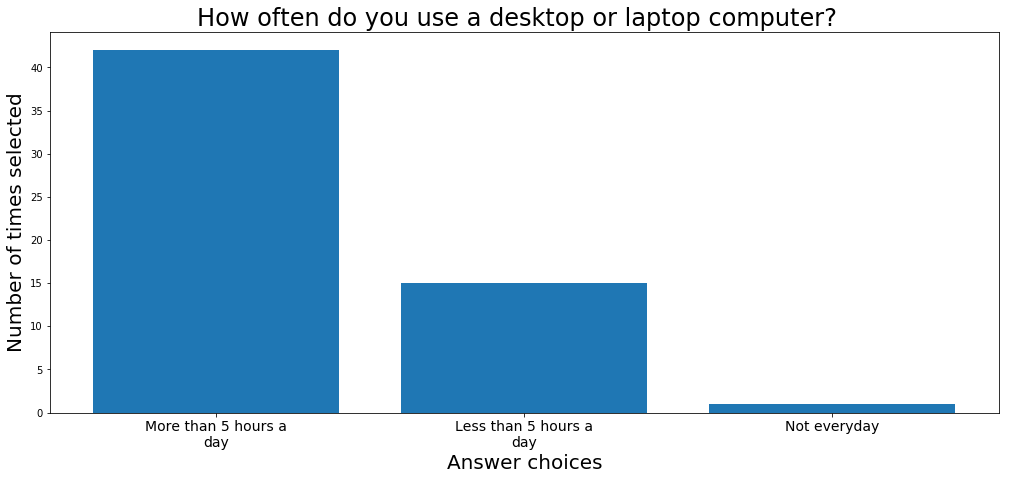

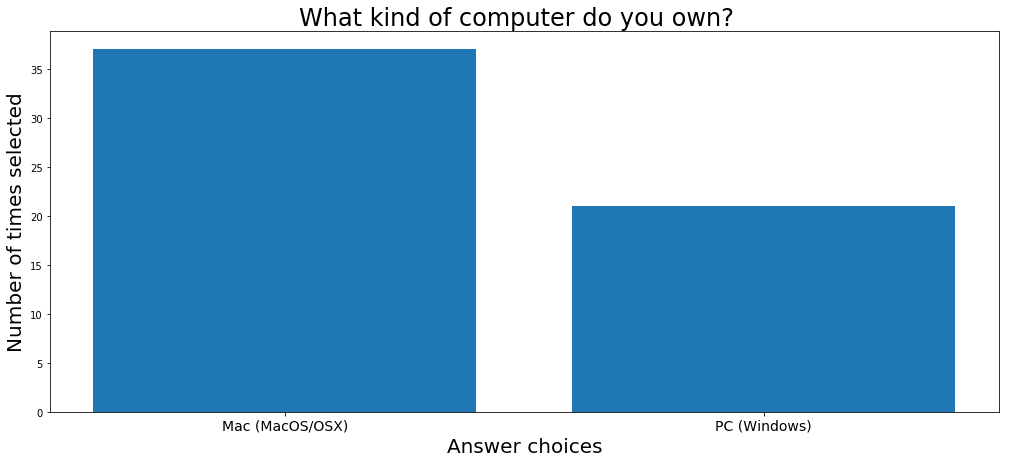

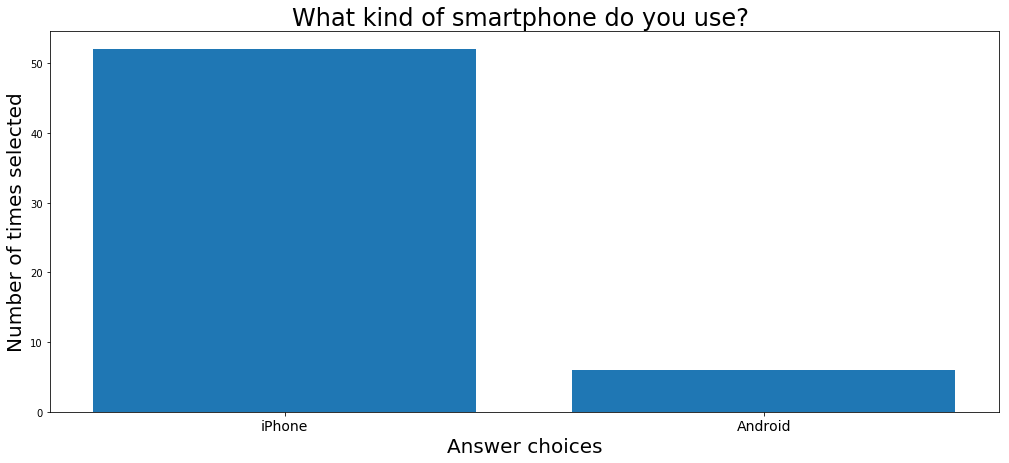

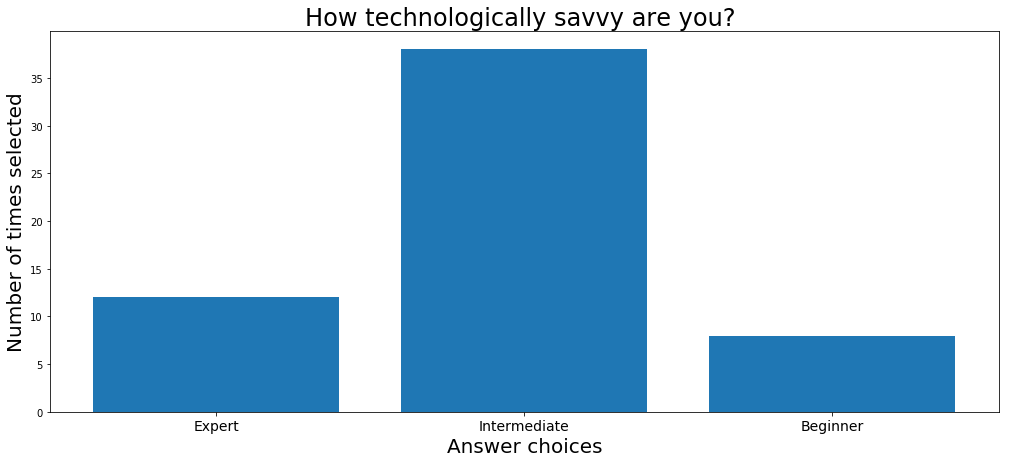

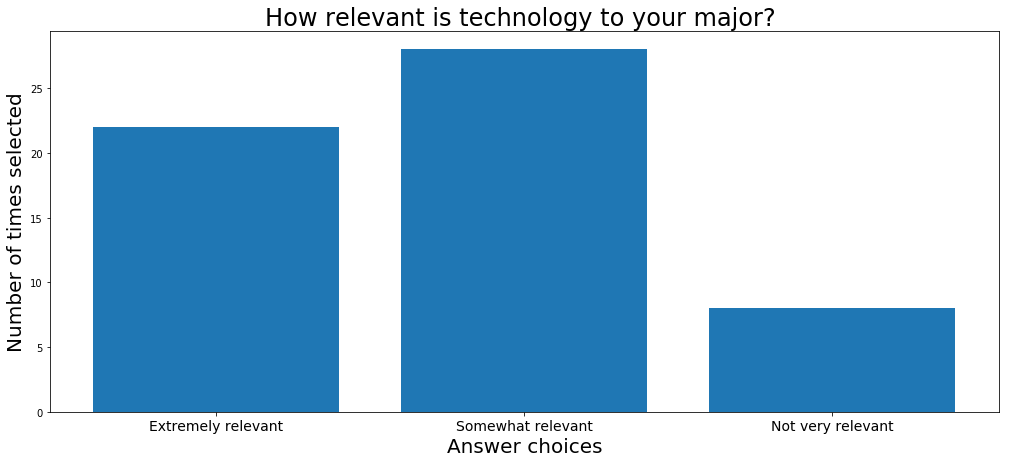

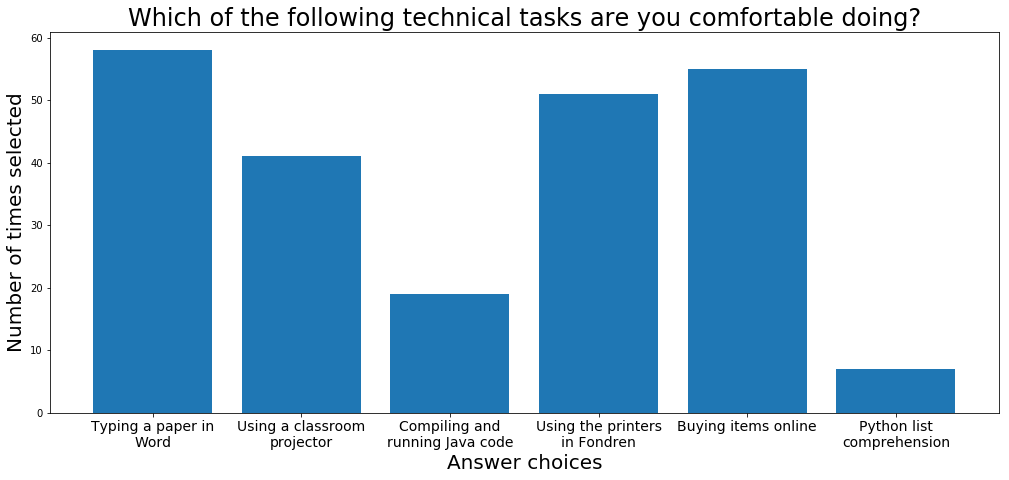

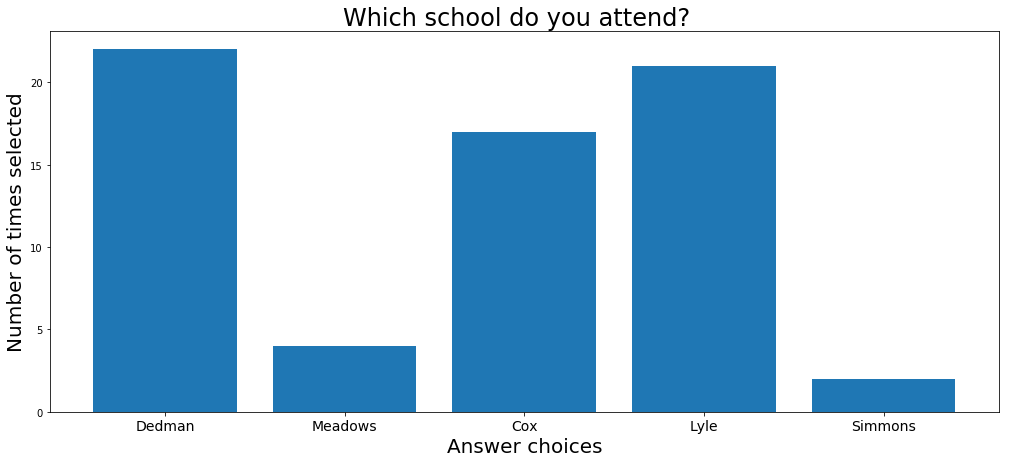

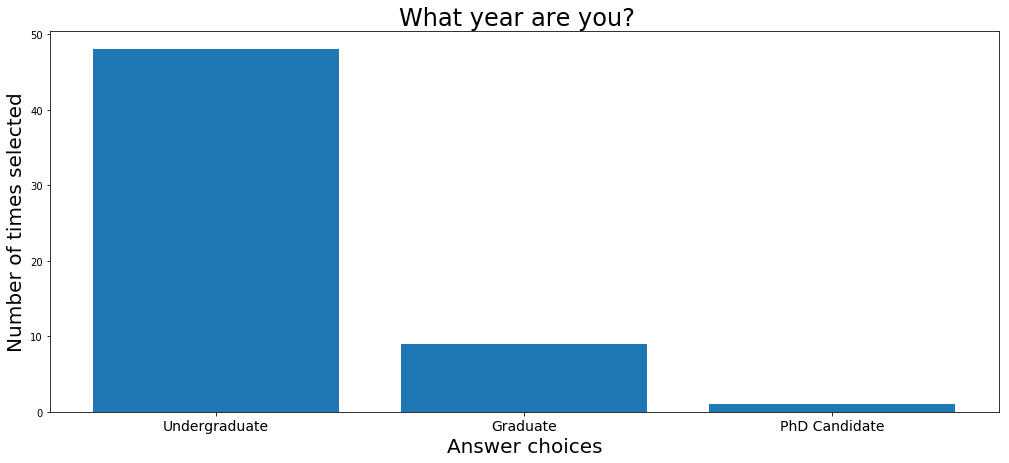

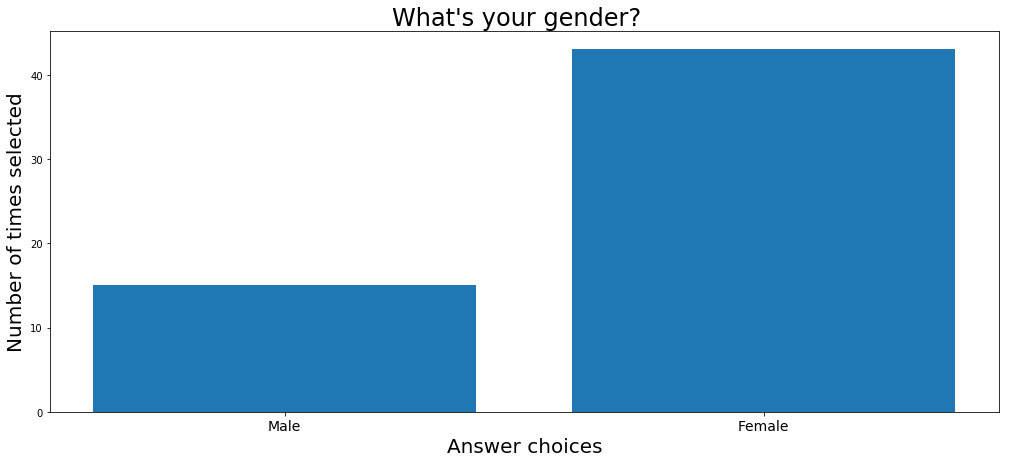

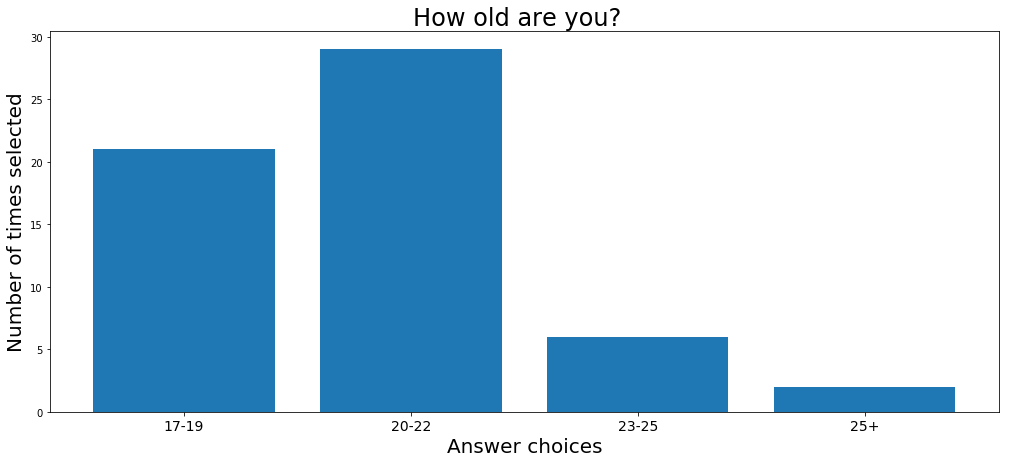

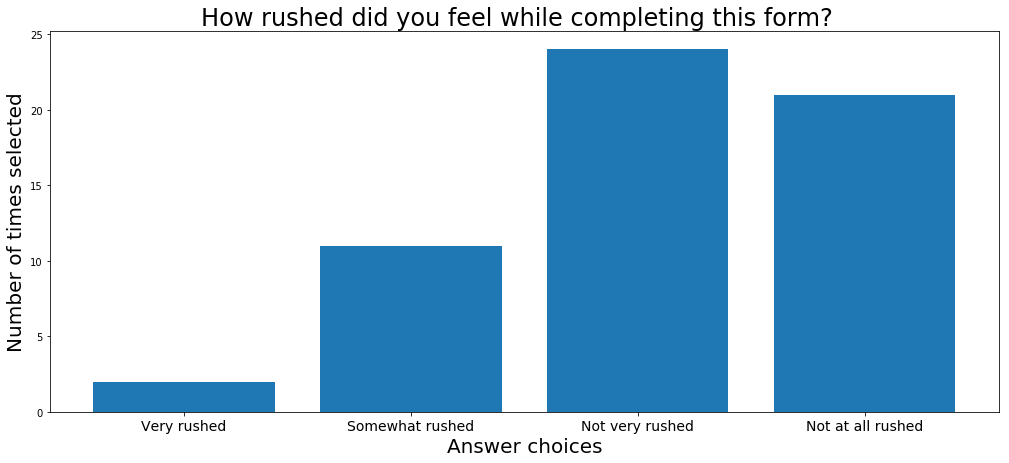

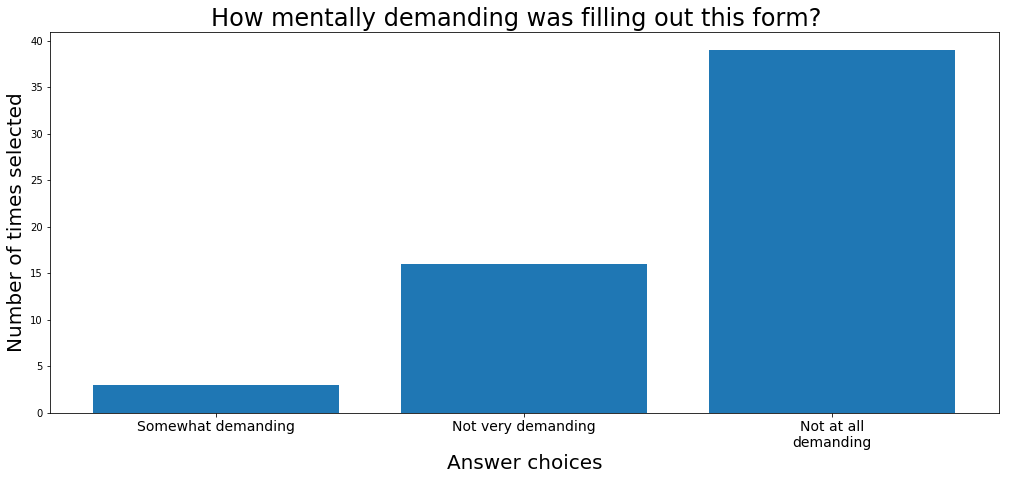

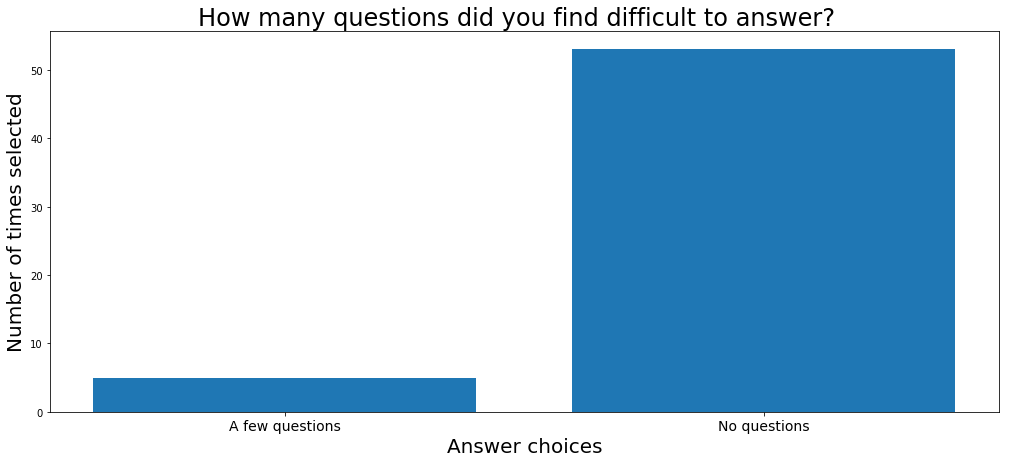

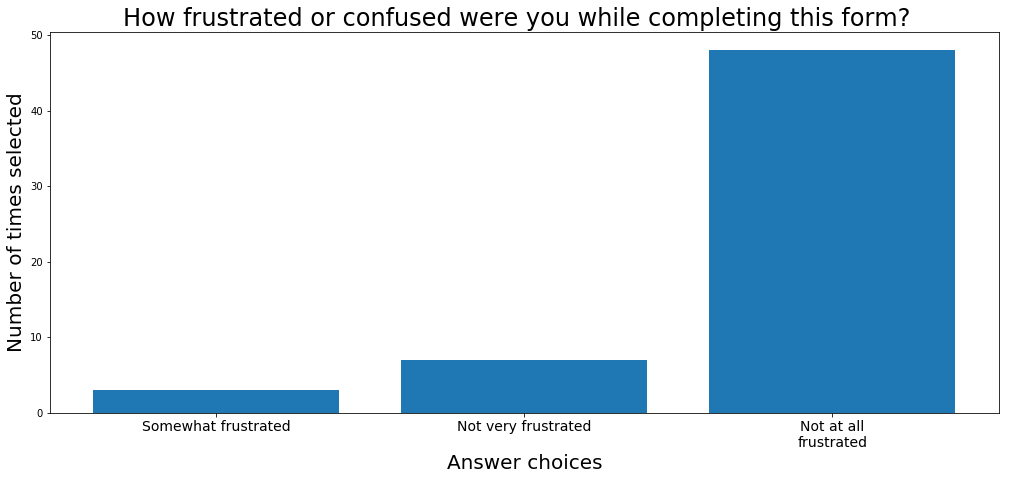

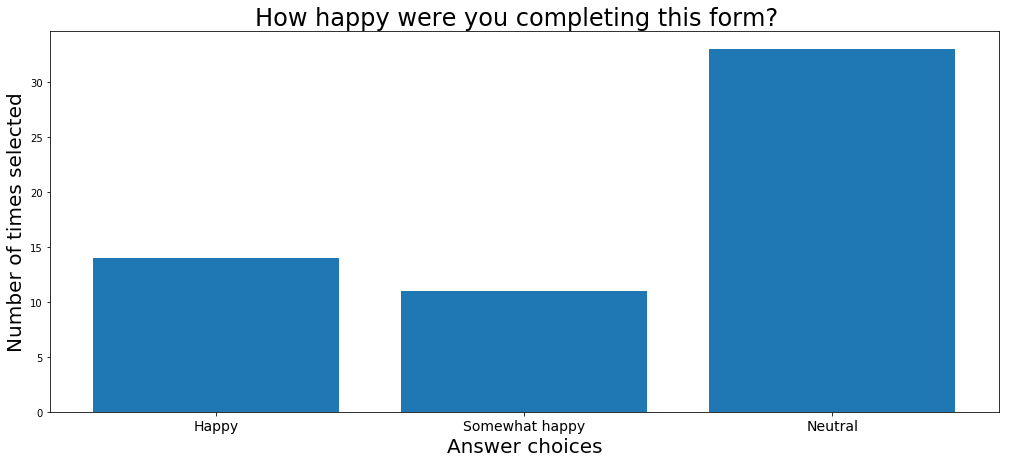

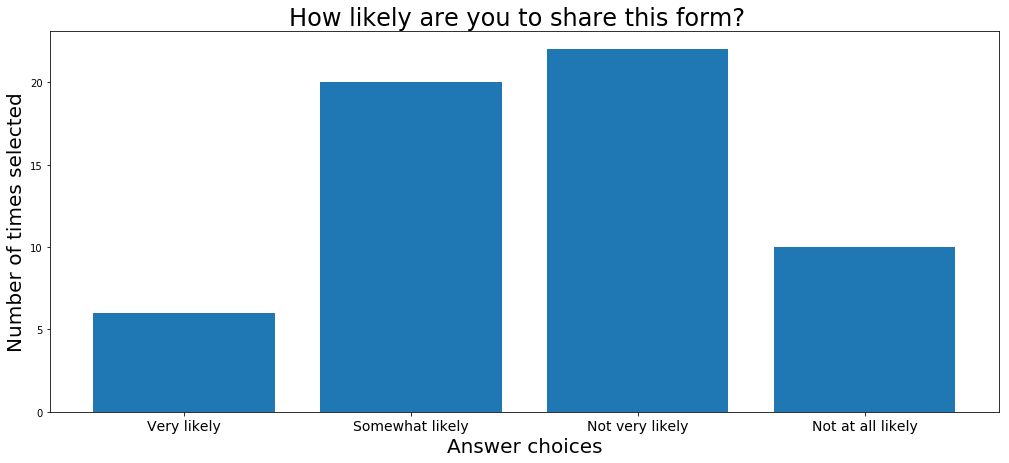

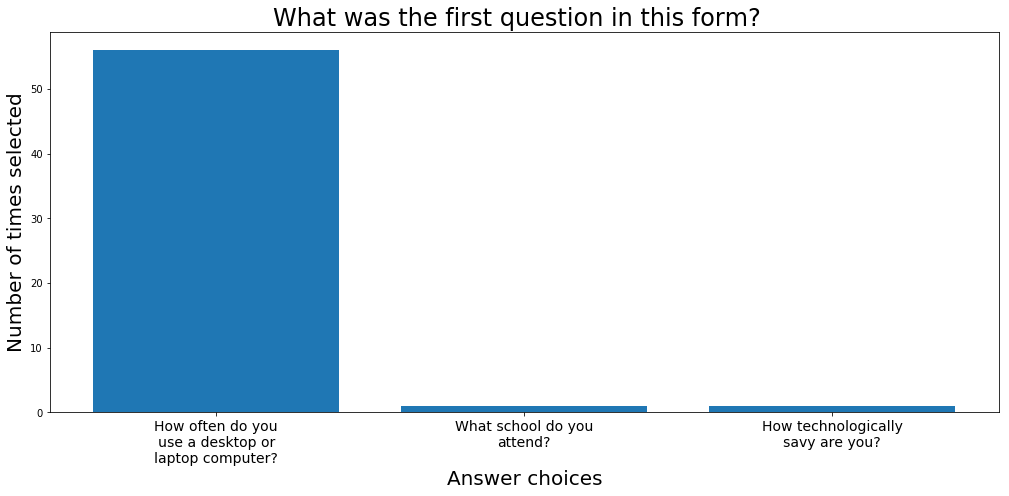

In [27]:
for r in range(len(responses)):
    # total numbers of times options were chosen
    totalled_answers = responses[r].values()
    
    # text of questions and answers
    title = list(survey_questions.keys())[r]
    choices = list(survey_questions.values())[r]
    
    selected_choices = []
    
    # remove the choices that were never selected
    for c in range(1, len(choices)+1):
        if c in sorted(responses[r].keys()):
            selected_choices.append(choices[c-1])
            
    # wrap words if too long
    selected_choices = [ '\n'.join(wrap(sc, 19)) for sc in selected_choices ]
            
    # logic for building bar chart
    y_pos = np.arange(len(selected_choices))
    plt.figure(figsize=(17,7))
    plt.bar(y_pos, totalled_answers, align='center')
    plt.xticks(y_pos, selected_choices, size=14)
    plt.xlabel('Answer choices', size=20)
    plt.ylabel('Number of times selected', size=20)
    plt.title(title, size=24)
    
    plt.show()

# clean the plot object when done
plt.clf()
plt.cla()
plt.close()

In [28]:
dataset = [{'A':19, 'B':39, 'C':61, 'D':70},
           {'A':34, 'B':68, 'C':32, 'D':38},
           {'A':35, 'B':45, 'C':66, 'D':50},
           {'A':23, 'B':23, 'C':21, 'D':16},
           {'A':35, 'B':45, 'C':66, 'D':50}]
            # row = answer choice
            # key = color scheme
            # value = number of people w that color
            # who made that choice
    
data_orders = [['A', 'B', 'C', 'D'], 
               ['B', 'A', 'C', 'D'], 
               ['A', 'B', 'D', 'C'], 
               ['B', 'A', 'C', 'D'],
               ['A', 'B', 'C', 'D']]

In [39]:
question_3_1 = df[['3_1', 'themeChosen']].groupby(
    ['themeChosen', '3_1']).size()
print(question_3_1)

num_people = list(question_3_1.as_matrix())
answer_choice = []
color_scheme = []

for i, j in question_3_1.index:
    color_scheme.append(i)
    answer_choice.append(j)

print(num_people)
print(answer_choice)
print(color_scheme)
print("-------")

data_set = []

for i in list(set(answer_choice)):
    cur_choice = {}
    j = 0
    while j < len(color):
        if answer_choice[j] == i:
            cur_choice[ answer_choice[j] ] = num_people[j]
        j += 1
    data_set.append(cur_choice)
data_set

themeChosen  3_1
1            1      1
             2      2
             3      4
             4      4
2            2      5
             3      7
             4      3
3            2      2
             3      5
             4      7
4            1      1
             2      2
             3      8
             4      7
dtype: int64
[1, 2, 4, 4, 5, 7, 3, 2, 5, 7, 1, 2, 8, 7]
[1, 2, 3, 4, 2, 3, 4, 2, 3, 4, 1, 2, 3, 4]
[1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4]
-------


[{1: 1}, {2: 2}, {3: 8}, {4: 7}]

In [ ]:
x = df[['3_1', 'themeChosen']].groupby(['themeChosen', '3_1']).size()
x.index[4]

In [ ]:

colors = ["r","g","b","y"]
names = sorted(dataset[0].keys())
values = np.array([[data[name] for name in order] for data,order in zip(dataset, data_orders)])
lefts = np.insert(np.cumsum(values, axis=1),0,0, axis=1)[:, :-1]
orders = np.array(data_orders)
bottoms = np.arange(len(data_orders))

for name, color in zip(names, colors):
    idx = np.where(orders == name)
    value = values[idx]
    left = lefts[idx]
    plt.bar(left=left, height=0.8, width=value, bottom=bottoms, 
            color=color, orientation="horizontal", label=name)
plt.yticks(bottoms+0.4, ["data %d" % (t+1) for t in bottoms])
plt.legend(loc="best", bbox_to_anchor=(1.0, 1.00))
plt.subplots_adjust(right=0.85)
plt.show()

# clean the plot object when done
plt.clf()
plt.cla()
plt.close()